# Cartpole Game with Framestack as input
end results: it always trains to only hold a certain action. i feel like the model also sees a correlation between the 2 actions. where 1 action will always have a lower q value than the other action. for example [-1, -4] are our predicted q values. if action 0 (-1) goes down for some reason action 1 (-4) also goes down and becomes something like this for example: [-8, -16]

### imports

In [2]:
import gymnasium
import cv2
import numpy as np
import PIL
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

print(gymnasium.__version__)

0.29.1


### functions

In [3]:
def preprocess_frame(frame):
    # Resize frame if needed
    frame = cv2.resize(frame, (84, 84))
    # Convert to grayscale
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Normalize pixel values
    frame = frame / 255.0
    # return
    return frame

def update_framestack(frame_stack, frame):
    """Moves every frame one place in the frame stack. starting on spot [0]. if the frame leaves spot [3], it gets removed from the frame stack. frame stack order [0] -> [1] -> [2] -> [3]"""
    # update frame stack
    frame_stack[:, :, 3] = frame_stack[:, :, 2]
    frame_stack[:, :, 2] = frame_stack[:, :, 1]
    frame_stack[:, :, 1] = frame_stack[:, :, 0]
    frame_stack[:, :, 0] = frame
    return frame_stack

# def get_other_action(num):
#     if num == 0:
#         return 1
#     else:
#         return 0

### define env

In [ ]:
# Define Environment
# - we need render mode as rgb_array to get the values of the screen as np array
env = gymnasium.make("CartPole-v1", render_mode="rgb_array")

### create model

In [80]:
# Q-network parameters
stack_size = 4
state_shape = (84, 84, 4)
action_size = env.action_space.n

# Q-network
model = Sequential()
model.add(Conv2D(32, (8, 8), strides=(4, 4),
          activation='relu', input_shape=state_shape))
model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(action_size, activation='linear'))
model.compile(loss='mse', optimizer=Adam(learning_rate=0.1))

# Training Loop

In [82]:
# Training parameters
episodes = 5  # amount of times we try to beat the game
gamma = 0.1  # Discount factor
exploration_rate = 1  # Exploration rate
epsilon_decay = 0
avg_score = 0


# Main training loop
for episode in range(episodes):
    # reset run
    state = env.reset()
    score = 0
    frame_stack = np.zeros((84, 84, stack_size))

    # game loop
    for i in range(200):
        # GET STATE
        # get screenshot of the game
        frame = env.render()
        # preprocess frame
        frame_preprocessed = preprocess_frame(frame)
        # update frame stack
        frame_stack = update_framestack(frame_stack, frame_preprocessed)

        # GET ACTION
        # Exploration-exploitation strategy
        if np.random.rand() <= exploration_rate:
            action = env.action_space.sample()  # Explore
        else:
            q_values = model.predict(np.reshape(frame_stack, (1, 84, 84, 4)))
            action = np.argmax(q_values)  # Exploit

        # DO ACTION
        # do action
        _, reward, dead, info, truncated = env.step(action)
        # +1 score
        score += reward
        # punishment for dying
        if dead:
            reward = -20
        # reward for completing
        elif truncated:
            reward = 100
            dead = True
        # reward for surviving
        else:
            reward = 5

        # make a copy of the frame stack
        new_frame_stack = frame_stack.copy()
        # get new screenshot of the game
        frame = env.render()
        # preprocess frame
        frame_preprocessed = preprocess_frame(frame)
        # update frame stack
        new_frame_stack = update_framestack(
            new_frame_stack, frame_preprocessed)

        # calucalte target q value with belman equation?
        target = reward + gamma * \
            np.max(model.predict(np.reshape(new_frame_stack, (1, 84, 84, 4))))

        # get current q_values
        q_values = model.predict(np.reshape(frame_stack, (1, 84, 84, 4)))
        # update the q_value so it takes into account the next states reward
        q_values[0][action] = target
        # Train the model on the updated Q-values
        model.fit(np.reshape(frame_stack, (1, 84, 84, 4)),
                  q_values, epochs=1, verbose=0)
        if dead:
            break
    exploration_rate -= epsilon_decay
    # print score
    print(f'Episode:{episode} Score:{score}')
    avg_score += score

# print average score
print(avg_score/episodes)
env.close()

1/1 [==============================] - 0s 53ms/step
Episode:0 Score:12.0
1/1 [==============================] - 0s 56ms/step
Episode:1 Score:28.0
1/1 [==============================] - 0s 74ms/step
Episode:2 Score:10.0
1/1 [==============================] - 0s 66ms/step
Episode:3 Score:13.0
1/1 [==============================] - 0s 63ms/step
Episode:4 Score:19.0
16.4


# Training Loop (For Debugging)

In [81]:
# Training parameters
episodes = 1  # amount of times we try to beat the game
gamma = 0.1  # Discount factor // idk what gamma does
exploration_rate = 0  # Exploration rate
epsilon_decay = 0
min_epsilon = 0.01
stack_size = 4
avg_score = 0


# Main training loop
for episode in range(episodes):
    # reset run
    state = env.reset()
    score = 0
    frame_stack = np.zeros((84, 84, stack_size))

    # game loop
    for i in range(200):
        # GET STATE
        # get screenshot of the game
        frame = env.render()
        # preprocess frame
        frame_preprocessed = preprocess_frame(frame)
        # update frame stack
        frame_stack = update_framestack(frame_stack, frame_preprocessed)

        # GET ACTION
        # Exploration-exploitation strategy
        if np.random.rand() <= exploration_rate:
            action = env.action_space.sample()  # Explore
        else:
            print("Model Predicting------")
            q_values = model.predict(np.reshape(frame_stack, (1, 84, 84, 4)))
            print(q_values)
            action = np.argmax(q_values)  # Exploit
            print(f'action: {action}')

        # DO ACTION
        # do action
        print("Do Action-----")
        _, reward, dead, info, truncated = env.step(action)
        print(f'initial reward: {reward}')
        # +1 score
        score += reward
        # punishment for dying
        if dead:
            reward = -20
        # reward for completing
        elif truncated:
            reward = 10
            dead = True
        else:
            reward=10
        print(f'modified reward: {reward}')

        # make a copy of the frame stack
        new_frame_stack = frame_stack.copy()
        # get new screenshot of the game
        frame = env.render()
        # preprocess frame
        frame_preprocessed = preprocess_frame(frame)
        # update frame stack
        new_frame_stack = update_framestack(
            new_frame_stack, frame_preprocessed)

        # calucalte target q value with belman equation?
        target = reward + gamma * np.max(model.predict(np.reshape(new_frame_stack, (1, 84, 84, 4))))
        print(f'target: {target}')

        # get current q_values
        print('Reprediction Model------')
        q_values = model.predict(np.reshape(frame_stack, (1, 84, 84, 4)))
        print(q_values)
        # update the q_value so it takes into account the next states reward
        q_values[0][action] = target
        print(q_values)
        # Train the model on the updated Q-values
        # model.fit(np.reshape(frame_stack, (1, 84, 84, 4)),q_values, epochs=1, verbose=0)
        print()
        if dead:
            break
    exploration_rate-=epsilon_decay
    # print score
    print(f'Episode:{episode} Score:{score}')
    avg_score += score

# print average score
print(avg_score/episodes)
env.close()

Model Predicting------
1/1 [==============================] - 0s 106ms/step
[[-0.06939338 -0.0555506 ]]
action: 1
Do Action-----
initial reward: 1.0
modified reward: 10
1/1 [==============================] - 0s 60ms/step
target: 10.008665009588004
Reprediction Model------
1/1 [==============================] - 0s 70ms/step
[[-0.06939338 -0.0555506 ]]
[[-0.06939338 10.008665  ]]

Model Predicting------
1/1 [==============================] - 0s 69ms/step
[[ 0.0866501  -0.17163962]]
action: 0
Do Action-----
initial reward: 1.0
modified reward: 10
1/1 [==============================] - 0s 63ms/step
target: 10.019183726608754
Reprediction Model------
1/1 [==============================] - 0s 70ms/step
[[ 0.0866501  -0.17163962]]
[[10.019184   -0.17163962]]

Model Predicting------
1/1 [==============================] - 0s 71ms/step
[[ 0.19183727 -0.0972562 ]]
action: 0
Do Action-----
initial reward: 1.0
modified reward: 10
1/1 [==============================] - 0s 70ms/step
target: 10.026264

# Last Frame Stack

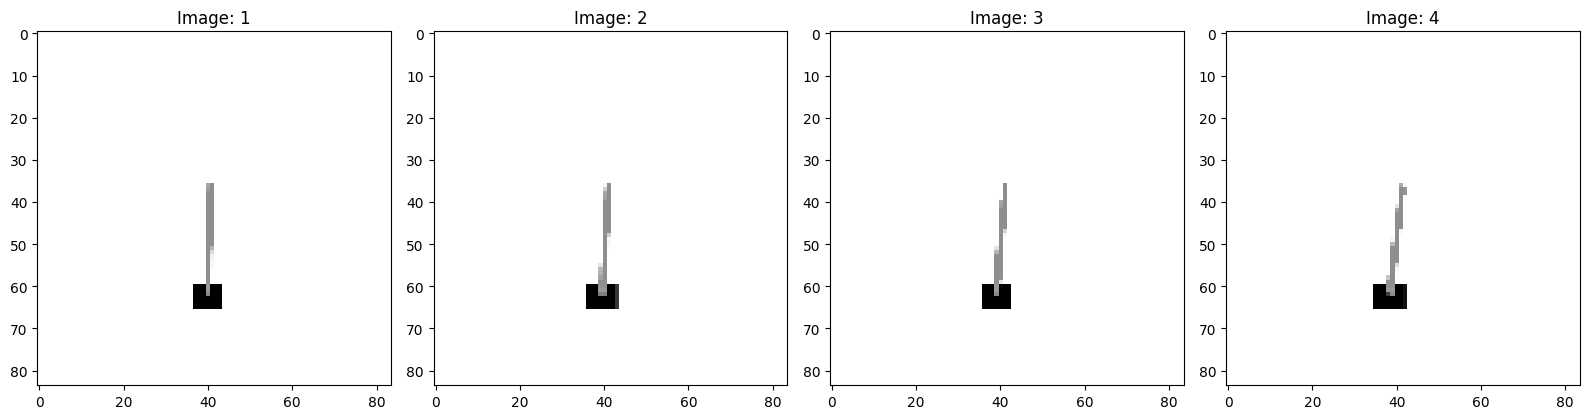

In [21]:
fig = plt.figure(figsize=(16, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(frame_stack[:, :, stack_size-i-1], cmap='gray')  # Assuming grayscale images
    plt.title('Image: ' + str(i+1))

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

# Current Prediction on the Last Frame Stack

In [17]:
model.predict(np.reshape(frame_stack, (1, 84, 84, 4)))


1/1 [==============================] - 0s 20ms/step


array([[ 4.6672783, -8.217273 ]], dtype=float32)

In [66]:
model.save('./data/')

INFO:tensorflow:Assets written to: ./data/assets


INFO:tensorflow:Assets written to: ./data/assets
